In [2]:
from methods.config import *
import numpy as np; rnd=np.random.default_rng()
import matplotlib.pyplot as plt; import matplotlib as mpl
import scipy.stats

import pickle
import methods.util as util
import methods.shared as shared
import methods.sim_barcodes as sim

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['svg.fonttype'] = 'none'

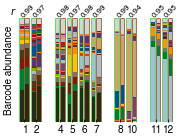

In [3]:
## Cecum feces correlations ##
expt = 'E1'
rep_mice= [1,2,4,5,6,7,8,10,11,12]
m_spacing = [1,2,4,5,6,7,9,10,12,13]

fig, ax = plt.subplots(1, 1, figsize=(3,2), frameon=False)

mouse = 1
fec_id, cec_id = shared.vivo_row_ids[(expt, mouse, 54)], shared.vivo_row_ids[(expt, mouse, 'cecum')]


fec_reads, cec_reads = shared.read_array[[fec_id, cec_id]]
fec_freqs = shared.calc_freqs(fec_reads)
cec_freqs = shared.calc_freqs(cec_reads)

sorting = np.argsort(cec_freqs)[::-1]
for m, mouse in zip(m_spacing, rep_mice):
    # print(shared.mouse_meta[expt][mouse])
    if mouse < 11:
        final_day = 54
    else:
        final_day = 51
    try:
        fec_id, cec_id = shared.vivo_row_ids[(expt, mouse, final_day)], shared.vivo_row_ids[(expt, mouse, 'cecum')]
        fec_reads, cec_reads = shared.read_array[[fec_id, cec_id]]
        fec_freqs = shared.calc_freqs(fec_reads)
        cec_freqs = shared.calc_freqs(cec_reads)


        cec_freqs = cec_freqs[sorting]
        fec_freqs = fec_freqs[sorting]
        large = cec_freqs > 10**-3

        cec_cg = np.zeros(large.sum() + 1)
        fec_cg = np.zeros(large.sum() + 1)
        bc_lst = np.zeros(large.sum() + 1, dtype='int')

        cec_cg[:-1] = cec_freqs[large]
        cec_cg[-1] = cec_freqs[~large].sum()

        fec_cg[:-1] = fec_freqs[large]
        fec_cg[-1] = fec_freqs[~large].sum()

        bc_lst[:-1] = np.arange(fec_reads.shape[0], dtype='int')[sorting][large]

        mask = (fec_cg != 0) * (cec_cg != 0)

        r = np.corrcoef(np.log(fec_cg[mask]), np.log(cec_cg[mask]))[0, 1]
        ax.text(2*m-0.7, 1.02, f'{r:.2f}', fontsize=8, rotation=45)

        width = 0.6
        ax.bar(2*m - 0.45, 1, bottom=0, lw=1.5, edgecolor='limegreen', width=width)
        ax.bar(2*m + 0.45, 1, bottom=0, lw=1.5, edgecolor='saddlebrown', width=width)
        for i, (bc, cec_f, fec_f) in enumerate(zip(bc_lst, cec_cg, fec_cg)):
            if i < large.sum()-1:
                ax.bar(2*m - 0.45, cec_f, bottom=cec_cg[:i].sum(), color=KELLY_COLORS[bc%len(KELLY_COLORS)], width=width)
                ax.bar(2*m + 0.45, fec_f, bottom=fec_cg[:i].sum(), color=KELLY_COLORS[bc%len(KELLY_COLORS)], width=width)
            else:
                ax.bar(2*m - 0.45, cec_f, bottom=cec_cg[:i].sum(), color='lightgrey', width=width)
                ax.bar(2*m + 0.45, fec_f, bottom=fec_cg[:i].sum(), color='lightgrey', width=width)

    except:
        continue

ax.text(-0.5, 1.05, r'$r$', fontsize=10, rotation=0)
ax.text(-1.5, 0.1, r'Barcode abundance', fontsize=10, rotation=90)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

ax.set_xticks(2*np.array(m_spacing))
ax.set_xticklabels(rep_mice, fontsize=10)
ax.set_yticks([])
fig.savefig(f'../figures/E1_cecum_feces_barplots.pdf', transparent=True, bbox_inches='tight')


/opt/anaconda3/envs/kim_barcodes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/opt/anaconda3/envs/kim_barcodes/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/anaconda3/envs/kim_barcodes/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/opt/anaconda3/envs/kim_barcodes/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/opt/anaconda3/envs/kim_barcodes/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_21332/4291448735.py:47: RuntimeWarning: invalid

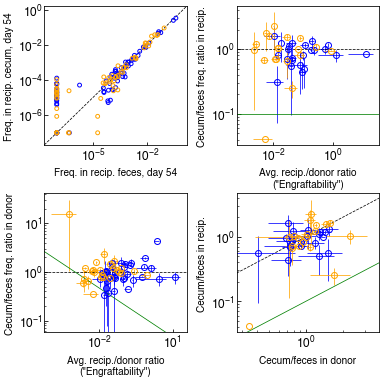

In [20]:
## are barcodes that fail to engraft still deteceted in cecum? 

## sort by "Engraftability"
## plot probability of detection in cecum (i.e. detected in both mice?)
## Just need a bit of Fig 2 data...

def nan_fn(x, fn):
    if np.isnan(x).all():
        return np.nan
    else:
        return fn(x)

with open(f'../data/pickled/E1_large_barcode_migration_ratios.pkl', 'rb') as f:
    large_barcode_migration_ratios = pickle.load(f)

fig = plt.figure(figsize=(6,6))
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1, 1], wspace=0.35, hspace=0.35, figure=fig)

freq_ax = fig.add_subplot(gs[0,0])
donor_bias_ax = fig.add_subplot(gs[1,0])
recip_bias_ax = fig.add_subplot(gs[0,1])
bias_vs_bias_ax = fig.add_subplot(gs[1, 1])


x, y = [], []
for barcode, recip_donor_ratios in large_barcode_migration_ratios.items():
    donor = recip_donor_ratios['donor']
    recip_ratios = recip_donor_ratios['recips']

    if donor in [4,5]:
        donors = [4,5]
        c = 'blue'
    else:
        donors = [6,7]
        c = 'orange'

    # freq ax
    pseudo = 1e-7
    donor_biases = []
    donor_final_freqs = []
    for d in donors:
        cec_donor_id = shared.vivo_row_ids[(expt, d, 'cecum')]
        fec_donor_id = shared.mouse_meta['E1'][d][1][-1]
        cec_donor = shared.freq_array[cec_donor_id, barcode] 
        fec_donor = shared.freq_array[fec_donor_id, barcode] 

        with np.errstate(divide='ignore'): donor_biases.append(cec_donor/fec_donor)
        donor_final_freqs.append(fec_donor)
    # if np.abs(np.log10((donor_final_freqs[0] + pseudo)/(donor_final_freqs[1] + pseudo))) > 0.5:
    #     z = np.argmax(donor_final_freqs)
    #     donor_biases = [donor_biases[z]]


    recip_biases = []
    for (recip, ratio) in recip_ratios:
        cec_id = shared.vivo_row_ids[(expt, recip, 'cecum')]
        fec_id = shared.mouse_meta['E1'][recip][1][-1] #last fecal tiempoint
        cec_freq = shared.freq_array[cec_id, barcode]
        fec_freq = shared.freq_array[fec_id, barcode] 
        freq_ax.scatter(fec_freq + pseudo, cec_freq + pseudo, color=c, s=15, marker='o', facecolor='none')
        with np.errstate(divide='ignore'): recip_biases.append(cec_freq/fec_freq)

    recip_biases = np.array(recip_biases)
    donor_biases = np.array(donor_biases)
    
    ratios = [ratio for (recip, ratio) in recip_ratios]
    ratios = np.array(ratios)

    mean_ratio, ratio_err = nan_fn(ratios, np.nanmean), nan_fn(ratios, np.nanstd)
    mean_donor_bias, donor_bias_err = nan_fn(donor_biases, np.nanmean), nan_fn(donor_biases, np.nanstd)
    mean_recip_bias, recip_bias_err = nan_fn(recip_biases, np.nanmean), nan_fn(recip_biases, np.nanstd)

    donor_bias_ax.errorbar(mean_ratio, mean_donor_bias, xerr=ratio_err, yerr=donor_bias_err, color=c, marker='o', mfc='none')
    recip_bias_ax.errorbar(mean_ratio, mean_recip_bias, xerr=ratio_err, yerr=recip_bias_err, color=c, marker='o', mfc='none')
    bias_vs_bias_ax.errorbar(mean_donor_bias, mean_recip_bias, xerr=donor_bias_err, yerr=recip_bias_err, color=c, marker='o', mfc='none')
    # recip_bias_ax.errorbar(np.mean(x), np.mean(y), xerr=np.abs(np.diff(x))/2, yerr=np.abs(np.diff(y))/2, color=c, marker='o', mfc='none')

for ax in [freq_ax, donor_bias_ax, recip_bias_ax, bias_vs_bias_ax]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_facecolor('white')


freq_ax.set_xlabel('Freq. in recip. feces, day 54')
freq_ax.set_ylabel('Freq. in recip. cecum, day 54')
util.plot_diagonal(freq_ax)
util.plot_diagonal(bias_vs_bias_ax)

donor_bias_ax.axhline(1, color='k', linestyle='--')
recip_bias_ax.axhline(1, color='k', linestyle='--')

donor_bias_ax.set_xlabel('Avg. recip./donor ratio\n("Engraftability")')
recip_bias_ax.set_xlabel('Avg. recip./donor ratio\n("Engraftability")')
donor_bias_ax.set_ylabel('Cecum/feces freq. ratio in donor')
recip_bias_ax.set_ylabel('Cecum/feces freq. ratio in recip.')

bias_vs_bias_ax.set_xlabel('Cecum/feces in donor')
bias_vs_bias_ax.set_ylabel('Cecum/feces in recip.')

donor_bias_ax.axline( (10**-3, 10**0),(10**0, 10**-1), color='green')
recip_bias_ax.axline( (10**-3, 10**-1),(10**-2, 10**-1), color='green')
bias_vs_bias_ax.axline( (7*10**-1, 7*10**-2),(2, 2*10**-1) , color='green')


fig.savefig(f'../figures/E1_cecum_vs_engraftment.pdf', format='pdf', transparent=True)